In [62]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image


In [63]:
Dataset_path="Downloads/exam"
IMG_SIZE=(224,224)
BATCH_SIZE=32
SEED=42

In [64]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    Dataset_path,
    validation_split=0.3,
    subset='training',
    seed=SEED,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
full_val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    Dataset_path,
    validation_split=0.3,
    subset='validation',
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

train_size=len(train_ds)
val_size=len(full_val_ds)//2
test_size=len(full_val_ds)-val_size

valid_ds=full_val_ds.take(val_size)
test_ds=full_val_ds.skip(val_size)


Found 1000 files belonging to 2 classes.
Using 700 files for training.
Found 1000 files belonging to 2 classes.
Using 300 files for validation.


In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [66]:
model=Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3), padding='same', name='conv1'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2),padding='same'),
    Conv2D(128,(3,3),activation='relu', padding='same'),
    MaxPooling2D((2,2),padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2),padding='same'),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2),padding='same'),
    Conv2D(128,(3,3),activation='relu', padding='same'),
    MaxPooling2D((2,2),padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2),padding='same'),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2),padding='same'),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 28, 28, 128)     

In [67]:
history=model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=1)

22/22 [==============================] - 35s 2s/step - loss: 0.9207 - accuracy: 0.5243 - val_loss: 0.6821 - val_accuracy: 0.5188


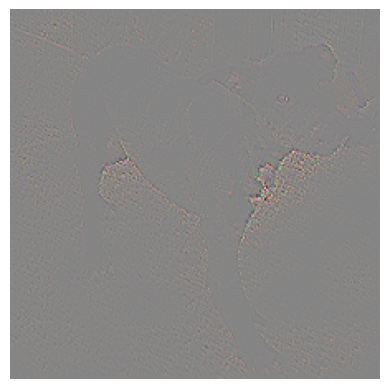

In [88]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define custom guided ReLU
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, tf.float32) * tf.cast(x > 0, tf.float32) * dy
    return tf.nn.relu(x), grad

# Function to override ReLU gradients globally
def replace_relu_with_guided():
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.activation = guided_relu

# Preprocessing
def preprocess(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Guided Backpropagation function
def guided_backprop(model, img):
    img = tf.expand_dims(preprocess(img), axis=0)
    with tf.GradientTape() as tape:
        tape.watch(img)
        pred = model(img)
        loss = pred[:, 0]
    grads = tape.gradient(loss, img)
    return grads

# --- Usage ---
# Replace ReLU activations with guided ReLU without changing model structure
replace_relu_with_guided()

# Take one input image
for images, labels in train_ds.take(1):
    single_image = images[0].numpy()
    break

# Compute guided gradients
guided_grads = guided_backprop(model, single_image)

# Normalize for visualization
guided_grads = guided_grads[0].numpy()
guided_grads -= guided_grads.min()
guided_grads /= guided_grads.max() + 1e-8  # avoid division by zero

# Plot
plt.imshow(guided_grads, cmap='jet')
plt.axis('off')
plt.show()
